In [43]:
import sys

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import json
import requests
from app import log as logging
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import PIL.Image as Image  # Using PIL to handle images



2. Data Ingestion
    •	Identify at least two data sources (e.g., CSV files, REST APIs, database queries)
        •	Design scripts for data ingestion, ensuring:
        o	Automatic fetching of data periodically (e.g., daily or hourly)
        o	Error handling for failed ingestion attempts
        o	Logging for monitoring ingestion jobs
    •	Deliverables:
        o	Python scripts for ingestion (e.g., using pandas, requests etc.)
        o	A log file showing successful ingestion runs
        o	Screenshots of ingested data stored in raw format


In [44]:
#data integratin from CSV
try:
    logging.info("Attempting to load the dataset from CSV file.")
    df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    # Check if the dataset was loaded successfully
    if df.empty:
        logging.warning("The dataset is empty.")
    else:
        print(df.head(2))
        logging.info("Dataset loaded successfully.")
        logging.info(f"First few rows of the dataset:\n{df.head(2)}")  # Log the first few rows

except FileNotFoundError:
    logging.error("The file was not found. Please check the file path.")

except pd.errors.EmptyDataError:
    logging.error("The file is empty.")

except pd.errors.ParserError:
    logging.error("There was an issue parsing the file. Please check the file format.")

except PermissionError:
    logging.error("Permission denied. Please check your file permissions.")

except Exception as e:
    logging.error(f"An unexpected error occurred: {e}")



   CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0        1001  Female              0     Yes         No       1           No   
1        1002    Male              0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   

      PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Electronic check          29.85         29.85    No  
1      Mailed check          56.95        1889.5    No  

[2 rows x 21 columns]


data integration from REST API for every 1 min (example)

In [47]:

def fetch_api_data():
    try:
        logging.info("Attempting to fetch data from REST API.")
        url = "http://192.168.29.179:5000/get_data_from_csv"
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Convert response text (string) into JSON
            json_data = json.loads(response.text)  # Convert string to list of dicts

            # Ensure data is in expected format
            if isinstance(json_data, list): 
                column_order = list(json_data[0].keys())  
                api_df = pd.DataFrame(json_data,columns=column_order)  # Convert to DataFrame
                api_df.head(2)  # Print first few rows
                # Save raw data to a timestamped file
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                raw_data_path = f"./raw_data/api_data_{timestamp}.csv"
                api_df.to_csv(raw_data_path, index=False)
                logging.info(f"Raw data saved to: {raw_data_path}")
            else:
                logging.error("API response is not a list of dictionaries or is empty.")
        else:
            logging.error(f"API request failed with status code: {response.status_code}")
    except Exception as e:
        logging.error(f"An error occurred while fetching API data: {e}")

# Schedule the function to run hourly
if __name__ == "__main__":
    import schedule
    # Schedule the function to run every 1 minute
    schedule.every(1).minutes.do(fetch_api_data)

    start_time = time.time()  # Record start time

    while True:
        schedule.run_pending()
        time.sleep(1)
    
        # Stop execution after 5 minutes
        if time.time() - start_time >= 5 * 60:
            print("Stopping scheduled task after 5 minutes.")
            break
    logging.info("API data ingestion scheduler started.")


Stopping scheduled task after 5 minutes.


In [49]:

#print files in raw_data folder
def print_tree(startpath, indent="  "):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent_space = indent * level
        print(f"{indent_space}📂 {os.path.basename(root)}/")
        sub_indent = indent * (level + 1)
        for file in files:
            print(f"{sub_indent}📄 {file}")

# Change the directory path to the folder you want to print
folder_path = "./raw_data"  # Replace with your actual folder path

# Ensure the folder exists
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    logging.info(f"Contents of the folder '{folder_path}':")
    print_tree(folder_path)
else:
    logging.error(f"The folder '{folder_path}' does not exist or is not a directory.")


📂 raw_data/
  📄 api_data_20250313_124725.csv
  📄 api_data_20250313_124825.csv
  📄 api_data_20250313_124926.csv
  📄 api_data_20250313_125026.csv


In [50]:
#fetch data from database and store in a dataframe

from sqlalchemy import create_engine, exc
import pandas as pd

try:
    logging.info("Creating an SQLAlchemy engine for SQLite.")
    engine = create_engine("sqlite:///./db/database.db")

    logging.info("Fetching the entire table 'customer_service' into a Pandas DataFrame.")
    database_df = pd.read_sql_table("customer_service", con=engine)

    # Log success and display the first few rows
    logging.info("Data loaded successfully from the database.")
    logging.info(f"First few rows of the DataFrame:\n{database_df.head(2)}")

except exc.OperationalError as e:
    logging.error(f"Unable to connect to the database. Details: {e}")

except exc.NoSuchTableError:
    logging.error("The specified table 'customer_service' does not exist in the database.")

except exc.SQLAlchemyError as e:
    logging.error(f"An SQLAlchemy error occurred: {e}")

except Exception as e:
    logging.error(f"An unexpected error occurred: {e}")

In [52]:
database_df.head(2)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEg,Female,0,True,True,1,True,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,True
1,7590-VHVEG,Female,0,True,True,1,True,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,True


In [51]:
#fetching data from api and storing it in a dataframe

# Initialize an empty DataFrame
api_df = pd.DataFrame()

# API endpoint
url = "http://192.168.29.179:5000/get_data_from_csv"

try:
    logging.info(f"Making a GET request to the API: {url}")
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        logging.info("API request successful. Processing response...")
        try:
            # Convert response text (string) into JSON
            json_data = json.loads(response.text)  # Convert string to list of dicts

            # Ensure data is in expected format
            if isinstance(json_data, list) and len(json_data) > 0:
                logging.info("JSON data is valid and non-empty.")
                # Extract column names from the first dictionary in the list
                column_order = list(json_data[0].keys())

                # Convert JSON data to DataFrame
                api_df = pd.DataFrame(json_data, columns=column_order)

                # Log success and display the first few rows
                logging.info("Data successfully converted to DataFrame.")
                logging.info(f"First few rows of the DataFrame:\n{api_df.head(2)}")
            else:
                logging.error("API response is not a list of dictionaries or is empty.")
        except json.JSONDecodeError as e:
            logging.error(f"JSON Decode Error: The API response is not valid JSON. Details: {e}")
        except KeyError as e:
            logging.error(f"Key Error: The JSON structure is not as expected. Details: {e}")
        except Exception as e:
            logging.error(f"An unexpected error occurred while processing the API response. Details: {e}")
    else:
        logging.error(f"API request failed with status code {response.status_code}.")
except requests.exceptions.RequestException as e:
    logging.error(f"Request Error: Unable to connect to the API. Details: {e}")
except Exception as e:
    logging.error(f"An unexpected error occurred during the API request. Details: {e}")

# Display the DataFrame (if successfully created)
if not api_df.empty:
    logging.info("Final DataFrame:")
    logging.info(f"\n{api_df.head(2)}")
else:
    logging.warning("No data was loaded into the DataFrame.")


In [53]:
api_df.head(2)

,Churn,Contract,CustomerID,Dependents,DeviceProtection,Gender,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,...,PaperlessBilling,Partner,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,Tenure,TotalCharges
0,No,Month-to-month,1001,No,No,Female,DSL,29.85,No phone service,Yes,...,Yes,Yes,Electronic check,No,0,No,No,No,1,29.85
1,No,One year,1002,No,Yes,Male,DSL,56.95,No,No,...,No,No,Mailed check,Yes,0,No,No,No,34,1889.5


3. Raw Data Storage
•	Store ingested data in a data lake or storage system (e.g., AWS S3, Google Cloud Storage, HDFS, or a local filesystem)
•	Design an efficient folder/bucket structure:
o	Partition data by source, type, and timestamp
•	Deliverables:
o	Folder/bucket structure documentation
o	Python code demonstrating the upload of raw data to the storage system


In [54]:
# Save the DataFrame to a CSV file with a timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
raw_data_path = f"./raw_data_csv/csv_data_{timestamp}.csv"

try:
    df.to_csv(raw_data_path, index=False)
    # Log success
    logging.info(f"Data successfully saved to: {raw_data_path}")
    # Print success
    print(f"Data successfully saved to: {raw_data_path}")
except Exception as e:
    # Log error
    logging.error(f"Failed to save data to {raw_data_path}. Error: {e}")
    # Print error
    print(f"Failed to save data to {raw_data_path}. Error: {e}")

Data successfully saved to: ./raw_data_csv/csv_data_20250313_125238.csv


In [55]:

#print files in raw_data folder
def print_tree(startpath, indent="  "):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent_space = indent * level
        print(f"{indent_space}📂 {os.path.basename(root)}/")
        sub_indent = indent * (level + 1)
        for file in files:
            print(f"{sub_indent}📄 {file}")

# Change the directory path to the folder you want to print
folder_path = "./raw_data_csv"  # Replace with your actual folder path

# Ensure the folder exists
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    logging.info(f"Contents of the folder '{folder_path}':")
    print_tree(folder_path)
else:
    logging.error(f"The folder '{folder_path}' does not exist or is not a directory.")


📂 raw_data_csv/
  📄 csv_data_20250313_125238.csv


4. Data Validation
•	Implement data validation checks to ensure data quality:
o	Check for missing or inconsistent data
o	Validate data types, formats, and ranges
o	Identify duplicates or anomalies
•	Generate a comprehensive data quality report
•	Deliverables:
o	A Python script for automated validation (e.g., using pandas, great_expectations, or pydeequ)
o	Sample data quality report in PDF or CSV format, summarizing issues and resolutions


In [59]:
df.describe()

,CustomerID,SeniorCitizen,Tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,4522.000000,0.162147,32.371149,64.761692
std,2033.283305,0.368612,24.559481,30.090047
min,1001.000000,0.000000,0.000000,18.250000
25%,2761.500000,0.000000,9.000000,35.500000
50%,4522.000000,0.000000,29.000000,70.350000
75%,6282.500000,0.000000,55.000000,89.850000
max,8043.000000,1.000000,72.000000,118.750000


In [60]:
df.dtypes

CustomerID            int64
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [61]:
df.info

<bound method DataFrame.info of       CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure  \
0           1001  Female              0     Yes         No       1   
1           1002    Male              0      No         No      34   
2           1003    Male              0      No         No       2   
3           1004    Male              0      No         No      45   
4           1005  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038        8039    Male              0     Yes        Yes      24   
7039        8040  Female              0     Yes        Yes      72   
7040        8041  Female              0     Yes        Yes      11   
7041        8042    Male              1     Yes         No       4   
7042        8043    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL 

In [64]:
import pandas as pd

def validate_data(data):
    issues = {}

    # Check for missing values
    missing_values = data[data.isnull().any(axis=1)]
    if not missing_values.empty:
        issues["Missing Values"] = missing_values

    # Check for duplicate rows
    duplicate_rows = data[data.duplicated()]
    if not duplicate_rows.empty:
        issues["Duplicate Rows"] = duplicate_rows

    # Check for data type mismatches in 'TotalCharges'
    if 'TotalCharges' in data.columns:
        non_numeric_total_charges = data[pd.to_numeric(data['TotalCharges'], errors='coerce').isna()]
        if not non_numeric_total_charges.empty:
            issues["Non-Numeric TotalCharges"] = non_numeric_total_charges
    if 'SeniorCitizen' in data.columns:
        non_numeric_total_charges = data[pd.to_numeric(data['SeniorCitizen'], errors='coerce').isna()]
        if not non_numeric_total_charges.empty:
            issues["Non-Numeric SeniorCitizen"] = non_numeric_total_charges
    if 'Tenure' in data.columns:
        non_numeric_total_charges = data[pd.to_numeric(data['Tenure'], errors='coerce').isna()]
        if not non_numeric_total_charges.empty:
            issues["Non-Numeric Tenure"] = non_numeric_total_charges

    return issues

# Validate the dataframe
issues_found = validate_data(df)

# Print detailed issues
for issue_type, records in issues_found.items():
    print(f"\n{issue_type}:")
    print(records)



Missing Values:
      CustomerID Gender  SeniorCitizen Partner Dependents  Tenure  \
6422        7423   Male              0     NaN         No      52   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
6422          Yes            No             DSL            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies  Contract  \
6422              Yes          No          No              No  One year   

     PaperlessBilling     PaymentMethod MonthlyCharges  TotalCharges Churn  
6422               No  Electronic check          53.75       2790.65    No  

[1 rows x 21 columns]

Non-Numeric TotalCharges:
      CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure  \
488         1489  Female              0     Yes        Yes       0   
753         1754    Male              0      No        Yes       0   
936         1937  Female              0     Yes        Yes       0   
1082        2083    Male              0     Yes        Yes       0


•	Generate a comprehensive data quality report


In [67]:
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas


# Data Quality Checks
missing_values = df.isnull().sum()
duplicate_rows = df.duplicated().sum()
data_types = df.dtypes
summary_stats = df.describe()

# Create a PDF
pdf_file = "data_quality_report.pdf"
c = canvas.Canvas(pdf_file, pagesize=letter)
width, height = letter

# Add Title
c.setFont("Helvetica-Bold", 16)
c.drawString(200, height - 50, "Data Quality Report")

# Add Missing Values
c.setFont("Helvetica-Bold", 12)
c.drawString(50, height - 100, "Missing Values:")
c.setFont("Helvetica", 10)
y = height - 120
for col, count in missing_values.items():
    c.drawString(50, y, f"{col}: {count} missing values")
    y -= 20

# Add Duplicate Rows
c.setFont("Helvetica-Bold", 12)
c.drawString(50, y - 20, "Duplicate Rows:")
c.setFont("Helvetica", 10)
c.drawString(50, y - 40, f"Total Duplicates: {duplicate_rows}")
y -= 60

# Add Data Types
c.setFont("Helvetica-Bold", 12)
c.drawString(50, y, "Data Types:")
c.setFont("Helvetica", 10)
y -= 20
for col, dtype in data_types.items():
    c.drawString(50, y, f"{col}: {dtype}")
    y -= 20

# Add Summary Statistics
c.setFont("Helvetica-Bold", 12)
c.drawString(50, y - 20, "Summary Statistics:")
c.setFont("Helvetica", 10)
y -= 40
for col in summary_stats.columns:
    c.drawString(50, y, f"{col}: Mean={summary_stats.loc['mean', col]:.2f}, Min={summary_stats.loc['min', col]}, Max={summary_stats.loc['max', col]}")
    y -= 20

# Save PDF
c.save()
print("Data Quality Report generated successfully:", pdf_file)


Data Quality Report generated successfully: data_quality_report.pdf


5. Data Preparation
•	Clean and preprocess the raw data:
o	Handle missing values (e.g., imputation or removal)
o	Standardize or normalize numerical attributes
o	Encode categorical variables using one-hot encoding or label encoding
•	Perform EDA to identify trends, distributions, and outliers.
•	Deliverables:
o	Jupyter notebook/Python script showcasing the data preparation process
o	Visualizations and summary statistics (e.g., histograms, box plots)
o	A clean dataset ready for transformations


In [68]:
def rectify_data(data):
    # Log and print start of rectification
    logging.info("Starting data rectification process.")
    print("Starting data rectification process.")

    # Rectify missing values
    try:
        if data.isnull().sum().any():
            logging.info("Missing values detected. Rectifying missing values.")
            print("Missing values detected. Rectifying missing values.")

            # Fill missing values with the mean for numeric columns
            numeric_columns = data.select_dtypes(include=['number']).columns
            data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

            # Fill missing values with the mode for categorical columns
            categorical_columns = data.select_dtypes(include=['object', 'category']).columns
            for col in categorical_columns:
                data[col] = data[col].fillna(data[col].mode()[0])  # Fill with most frequent value

            logging.info("Missing values rectified.")
            print("Missing values rectified.")
    except Exception as e:
        logging.error(f"Error while rectifying missing values: {e}")
        print(f"Error while rectifying missing values: {e}")

    # Rectify duplicate rows
    try:
        if data.duplicated().any():
            logging.info("Duplicate rows detected. Removing duplicates.")
            print("Duplicate rows detected. Removing duplicates.")
            data = data.drop_duplicates()
            logging.info("Duplicate rows removed.")
            print("Duplicate rows removed.")
    except Exception as e:
        logging.error(f"Error while removing duplicate rows: {e}")
        print(f"Error while removing duplicate rows: {e}")

    # Rectify data type mismatches for 'TotalCharges'
    try:
        if not pd.api.types.is_numeric_dtype(data['TotalCharges']):
            logging.info("Data type mismatch detected in 'TotalCharges'. Converting to numeric.")
            print("Data type mismatch detected in 'TotalCharges'. Converting to numeric.")
            data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
            data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())
            logging.info("'TotalCharges' rectified.")
            print("'TotalCharges' rectified.")
    except Exception as e:
        logging.error(f"Error while rectifying 'TotalCharges': {e}")
        print(f"Error while rectifying 'TotalCharges': {e}")

    # Rectify data type mismatches for 'SeniorCitizen'
    try:
        if not pd.api.types.is_numeric_dtype(data['SeniorCitizen']):
            logging.info("Data type mismatch detected in 'SeniorCitizen'. Converting to numeric.")
            print("Data type mismatch detected in 'SeniorCitizen'. Converting to numeric.")
            data['SeniorCitizen'] = pd.to_numeric(data['SeniorCitizen'], errors='coerce')
            data['SeniorCitizen'] = data['SeniorCitizen'].fillna(data['SeniorCitizen'].mean())
            logging.info("'SeniorCitizen' rectified.")
            print("'SeniorCitizen' rectified.")
    except Exception as e:
        logging.error(f"Error while rectifying 'SeniorCitizen': {e}")
        print(f"Error while rectifying 'SeniorCitizen': {e}")

    # Rectify data type mismatches for 'Tenure'
    try:
        if not pd.api.types.is_numeric_dtype(data['Tenure']):
            logging.info("Data type mismatch detected in 'Tenure'. Converting to numeric.")
            print("Data type mismatch detected in 'Tenure'. Converting to numeric.")
            data['Tenure'] = pd.to_numeric(data['Tenure'], errors='coerce')
            data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mean())
            logging.info("'Tenure' rectified.")
            print("'Tenure' rectified.")
    except Exception as e:
        logging.error(f"Error while rectifying 'Tenure': {e}")
        print(f"Error while rectifying 'Tenure': {e}")

    # Log and print completion of rectification
    logging.info("Data rectification process completed.")
    print("Data rectification process completed.")

    return data

# Example usage:
df = rectify_data(df)
validate_data(df)


Starting data rectification process.
Missing values detected. Rectifying missing values.
Missing values rectified.
Data type mismatch detected in 'TotalCharges'. Converting to numeric.
'TotalCharges' rectified.
Data rectification process completed.


{}

In [26]:
df.head(2)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1001,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1002,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [70]:
categorical_features = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                        'PaperlessBilling', 'PaymentMethod','Churn']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [71]:
df.head(2)

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1001,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,1002,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0


In [72]:
df.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Computing correlation with the 'Churn' column.
Correlation with 'Churn':
Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
CustomerID          0.010286
Gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
InternetService    -0.047291
Partner            -0.150448
Dependents         -0.164221
DeviceProtection   -0.178134
OnlineBackup       -0.195525
TotalCharges       -0.199428
TechSupport        -0.282492
OnlineSecurity     -0.289309
Tenure             -0.352229
Contract           -0.396713
Name: Churn, dtype: float64
Generating correlation heatmap.


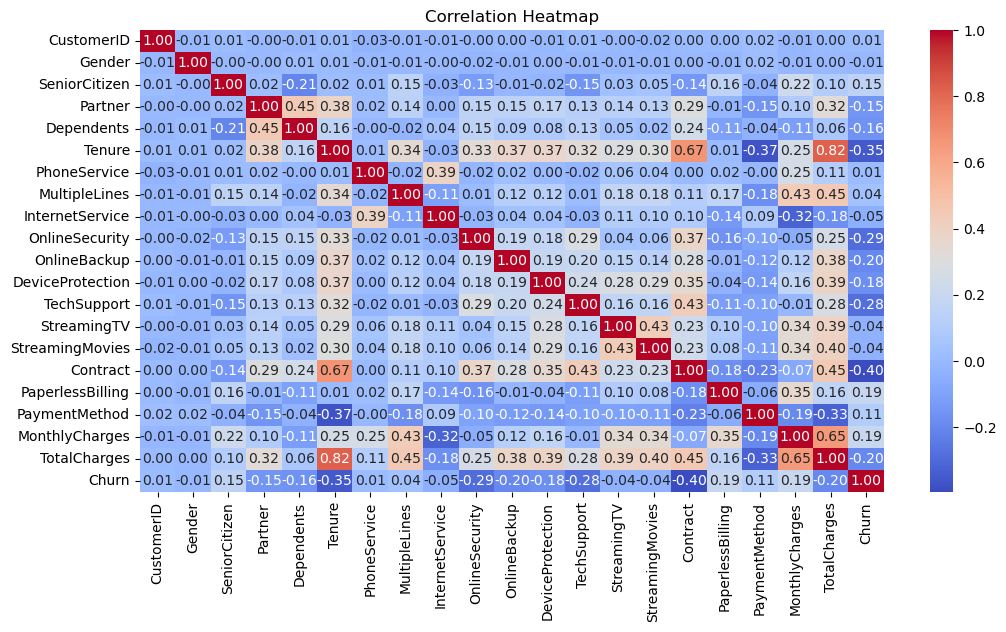

Correlation heatmap generated successfully.


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation with target column (e.g., 'Churn')
try:
    logging.info("Computing correlation with the 'Churn' column.")
    print("Computing correlation with the 'Churn' column.")

    correlation = df.corr()['Churn'].sort_values(ascending=False)
    logging.info(f"Correlation with 'Churn':\n{correlation}")
    print(f"Correlation with 'Churn':\n{correlation}")
except Exception as e:
    logging.error(f"Error while computing correlation: {e}")
    print(f"Error while computing correlation: {e}")

# Heatmap
try:
    logging.info("Generating correlation heatmap.")
    print("Generating correlation heatmap.")

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    logging.info("Correlation heatmap generated successfully.")
    print("Correlation heatmap generated successfully.")
except Exception as e:
    logging.error(f"Error while generating heatmap: {e}")
    print(f"Error while generating heatmap: {e}")


Useful Features for Churn Prediction

Highly correlated features (|correlation| > 0.2) → Strong impact on churn:
    Tenure (-0.35) → Longer tenure → Lower churn.
    Contract (-0.40) → Longer contracts → Lower churn.
    TechSupport (-0.28) → Having tech support reduces churn.
    OnlineSecurity (-0.29) → Security services reduce churn.
    TotalCharges (-0.20) → More total charges → Lower churn.
    OnlineBackup (-0.19) → Online backup reduces churn.

Moderately correlated features (|correlation| 0.1 - 0.2) → Medium impact:
    MonthlyCharges (0.19) → Higher monthly charges slightly increase churn.
    PaperlessBilling (0.19) → Paperless billing slightly increases churn.
    SeniorCitizen (0.15) → Older customers churn slightly more.
    PaymentMethod (0.10) → Payment method influences churn.


Weakly correlated features (|correlation| < 0.1) → Likely not useful:
    PhoneService (0.01)
    Gender (-0.008)
    StreamingTV (-0.03)
    StreamingMovies (-0.03)
    InternetService (-0.04)
    MultipleLines (0.03)


removing/droping Weakly correlated features (|correlation| < 0.1) → Likely not useful:


In [74]:
try:
    logging.info("Dropping specified columns from the DataFrame.")
    print("Dropping specified columns from the DataFrame.")

    # List of columns to drop
    columns_to_drop = ["PhoneService", "Gender", "StreamingTV", "InternetService", "MultipleLines", "SeniorCitizen", "PaymentMethod"]

    # Check if columns exist in the DataFrame
    missing_columns = [col for col in columns_to_drop if col not in df.columns]
    if missing_columns:
        logging.warning(f"The following columns do not exist in the DataFrame and will be skipped: {missing_columns}")
        print(f"The following columns do not exist in the DataFrame and will be skipped: {missing_columns}")

    # Drop the columns
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    logging.info("Specified columns dropped successfully.")
    print("Specified columns dropped successfully.")
    logging.info(f"Updated DataFrame columns: {df.columns.tolist()}")
    print(f"Updated DataFrame columns: {df.columns.tolist()}")
except Exception as e:
    logging.error(f"Error while dropping columns: {e}")
    print(f"Error while dropping columns: {e}")

Dropping specified columns from the DataFrame.
Specified columns dropped successfully.
Updated DataFrame columns: ['CustomerID', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [75]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df, columns):
    """
    Normalizes specified columns in the dataset.
    """
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df
df = normalize_data(df, [ 'Tenure', 'MonthlyCharges', 'TotalCharges'])
df

,CustomerID,Partner,Dependents,Tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,1001,1,0,0.013889,0,2,0,0,0,0,1,0.115423,0.001275,0
1,1002,0,0,0.472222,2,0,2,0,0,1,0,0.385075,0.215867,0
2,1003,0,0,0.027778,2,2,0,0,0,0,1,0.354229,0.010310,1
3,1004,0,0,0.625000,2,0,2,2,0,1,0,0.239303,0.210241,0
4,1005,0,0,0.027778,0,0,0,0,0,0,1,0.521891,0.015330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,8039,1,1,0.333333,2,0,2,2,2,1,1,0.662189,0.227521,0
7039,8040,1,1,1.000000,0,2,2,0,2,1,1,0.845274,0.847461,0
7040,8041,1,1,0.152778,2,0,0,0,0,0,1,0.112935,0.037809,0
7041,8042,1,0,0.055556,0,0,0,0,0,0,1,0.558706,0.033210,1


In [ ]:

df.columns



Index(['CustomerID', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

 Churn Distribution

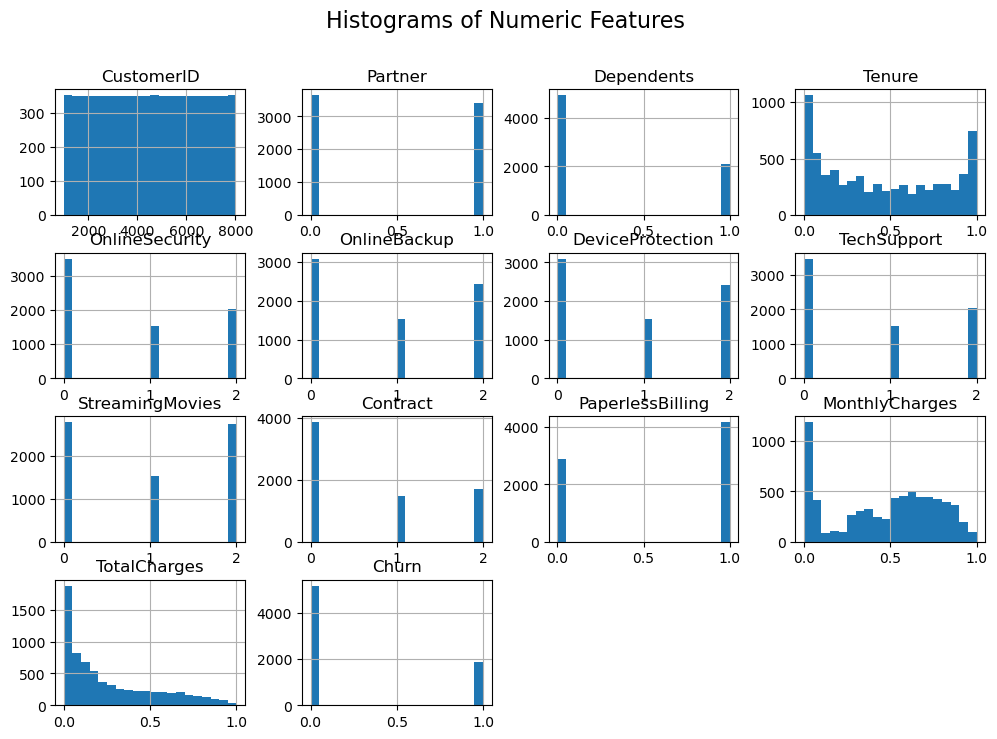

In [77]:
import matplotlib.pyplot as plt

# Plot histograms for numerical features
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()


Box Plots (Detect Outliers)

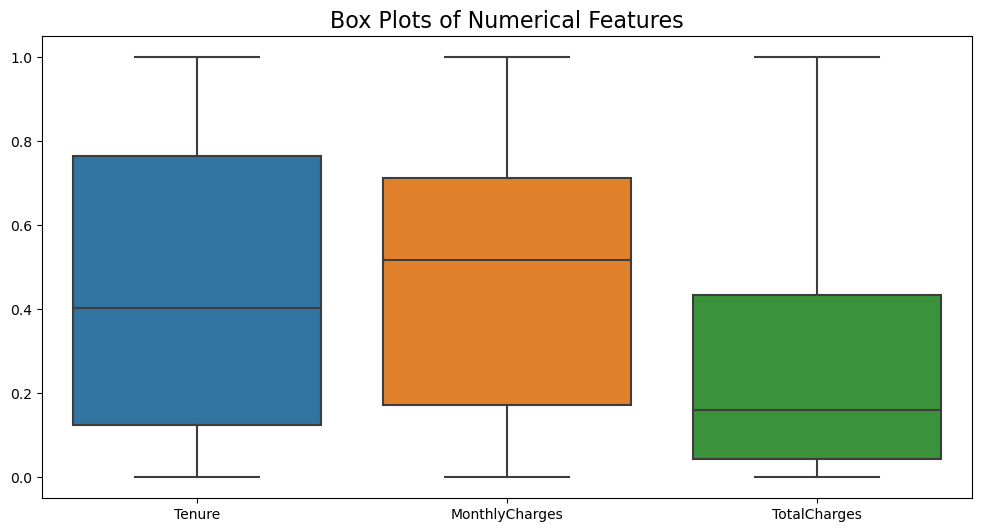

In [78]:
import seaborn as sns

# Box plot for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Tenure', 'MonthlyCharges', 'TotalCharges']])
plt.title("Box Plots of Numerical Features", fontsize=16)
plt.show()

6. Data Transformation and Storage
•	Perform transformations for feature engineering:
o	Create aggregated features (e.g., total spend per customer)
o	Derive new features (e.g., customer tenure, activity frequency)
o	Scale and normalize features where necessary
•	Store the transformed data in a relational database or a data warehouse.
•	Deliverables:
o	SQL schema design or database setup script
o	Sample queries to retrieve transformed data
o	A summary of the transformation logic applied


Data Transformation Function

In [79]:

def transform_data(df):
    """
    Perform feature engineering:
    - Aggregate total spend per customer
    - Calculate activity frequency
    - Normalize selected columns
    """
    df['TotalSpend'] = df['Tenure'] * df['MonthlyCharges']
    df['ActivityFrequency'] = np.random.randint(1, 10, size=len(df))  # Simulated activity frequency

    # Normalize selected columns
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df[['TotalSpend']] = scaler.fit_transform(
        df[['TotalSpend']]
    )
    # df['ActivityFrequency'] = scaler.fit_transform(df[['ActivityFrequency']])
    df['ActivityFrequency'] = df['ActivityFrequency'].round(2)
    df['TotalSpend'] = df['TotalSpend'].round(2)

    # # Convert Churn to numeric (Yes -> 1, No -> 0)
    # df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df
print(transform_data(df).head(2))

   CustomerID  Partner  Dependents    Tenure  OnlineSecurity  OnlineBackup  \
0        1001        1           0  0.013889               0             2   
1        1002        0           0  0.472222               2             0   

   DeviceProtection  TechSupport  StreamingMovies  Contract  PaperlessBilling  \
0                 0            0                0         0                 1   
1                 2            0                0         1                 0   

   MonthlyCharges  TotalCharges  Churn  TotalSpend  ActivityFrequency  
0        0.115423      0.001275      0        0.00                  1  
1        0.385075      0.215867      0        0.18                  1  


In [38]:
df.dtypes

CustomerID             int64
Partner                int64
Dependents             int64
Tenure               float64
OnlineSecurity         int64
OnlineBackup           int64
DeviceProtection       int64
TechSupport            int64
StreamingMovies        int64
Contract               int64
PaperlessBilling       int64
MonthlyCharges       float64
TotalCharges         float64
Churn                  int64
TotalSpend           float64
ActivityFrequency      int32
dtype: object

In [80]:
# Save as CSV
df.to_csv("./data/processed_customer_data_for_database.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


set_up database for processed dataframe

In [81]:
from sqlalchemy import create_engine, Column, Integer, String, DateTime,inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
# from constants import csv_file_path
from sqlalchemy import Column, String, Integer, Float
from sqlalchemy.ext.declarative import declarative_base
# Define paths relative to the project root
import os
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))  # Get the project root directory
DATABASE_URL = f'sqlite:///./db/database.db'  # Path to the database
csv_file_path = "./data/processed_customer_data_for_database.csv"  # Path to the CSV file
engine = create_engine(DATABASE_URL, echo=False)
import pandas as pd
# Base class for SQLAlchemy models
Base = declarative_base()

class customer(Base):
    __tablename__ = 'processed_customers_data'

    CustomerID = Column(Integer, primary_key=True)  # String ID
    Partner = Column(String(5))  # Yes/No -> String(5)
    Dependents = Column(String(5))
    Tenure = Column(Integer)  # Months
    PhoneService = Column(String(5))
    OnlineSecurity = Column(String(50))
    OnlineBackup = Column(String(50))
    DeviceProtection = Column(String(50))
    TechSupport = Column(String(50))
    StreamingMovies = Column(String(50))
    Contract = Column(String(50))  # "Month-to-month", "One year", "Two year"
    PaperlessBilling = Column(String(5))  # Yes/No
    MonthlyCharges = Column(Float)  # Numeric
    TotalCharges = Column(Float)  # Numeric
    Churn = Column(String(5))  # Yes/No -> String(5)
    TotalSpend = Column(Float)  # Aggregated Feature
    ActivityFrequency = Column(Integer)  # Derived Feature


# Create all tables
Base.metadata.create_all(engine)

# Session factory
SessionLocal = sessionmaker(bind=engine)

In [33]:
df.columns

Index(['CustomerID', 'Partner', 'Dependents', 'Tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'TotalSpend', 'ActivityFrequency'],
      dtype='object')

In [82]:
def insert_data_from_csv(csv_file):
    """Insert data from a CSV file into the database."""
    df = pd.read_csv(csv_file)

    # Insert data into the database
    df.to_sql('processed_customers_data', con=engine, if_exists='replace', index=False)
    print("Data inserted successfully!")

# Insert CSV data into the database
insert_data_from_csv(csv_file_path)


Data inserted successfully!


Sample Queries to Retrieve Transformed Data

In [83]:
def get_top_customers():
    """Fetch top 5 customers with the highest TotalSpend."""
    query = "SELECT CustomerID, TotalSpend FROM processed_customers_data ORDER BY TotalSpend DESC LIMIT 5;"
    df = pd.read_sql(query, con=engine)
    print(df)

get_top_customers()


   CustomerID  TotalSpend
0        5587        1.00
1        3116        0.99
2        4206        0.99
3        5156        0.99
4        5611        0.99


 Function to Retrieve Customers Who Churned

In [84]:
def get_churned_customers():
    """Retrieve all customers who churned (Churn = 1)."""
    query = "SELECT * FROM processed_customers_data WHERE Churn = 1;"
    df = pd.read_sql(query, con=engine)
    return df

# Fetch churned customers
churned_customers = get_churned_customers()
churned_customers.head(2)


,CustomerID,Partner,Dependents,Tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,TotalSpend,ActivityFrequency
0,1003,0,0,0.027778,2,2,0,0,0,0,1,0.354229,0.01031,1,0.01,8
1,1005,0,0,0.027778,0,0,0,0,0,0,1,0.521891,0.01533,1,0.01,3


 Function to Get Average Monthly Charges by Contract Type

In [85]:
def avg_monthly_charges_by_contract():
    """Calculate the average monthly charges for each contract type."""
    query = """
        SELECT Contract, AVG(MonthlyCharges) as AvgMonthlyCharges
        FROM processed_customers_data
        GROUP BY Contract;
    """
    df = pd.read_sql(query, con=engine)
    print(df)

avg_monthly_charges_by_contract()


   Contract  AvgMonthlyCharges
0         0           0.479089
1         1           0.465658
2         2           0.423089


7. Feature Store
•	Implement a feature store to manage engineered features:
o	Define metadata for each feature (e.g., description, source, version)
o	Use a feature store tool (e.g., Feast) or a custom solution
•	Automate feature retrieval for training and inference
•	Deliverables:
o	Feature store configuration/code
o	Sample API or query demonstrating feature retrieval
o	Documentation of feature metadata and versions


In [86]:
# Define features and target
# X = df.drop(columns=[ 'Churn', 'Churn_30', 'Churn_60', 'Churn_90'])
# y = df[['Churn_30', 'Churn_60', 'Churn_90']]
X = df.drop(columns=["CustomerID",'Churn'])
y = df[['Churn']]

In [87]:

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
print(X.columns)
print(y.columns)

Index(['Partner', 'Dependents', 'Tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'TotalSpend',
       'ActivityFrequency'],
      dtype='object')
Index(['Churn'], dtype='object')


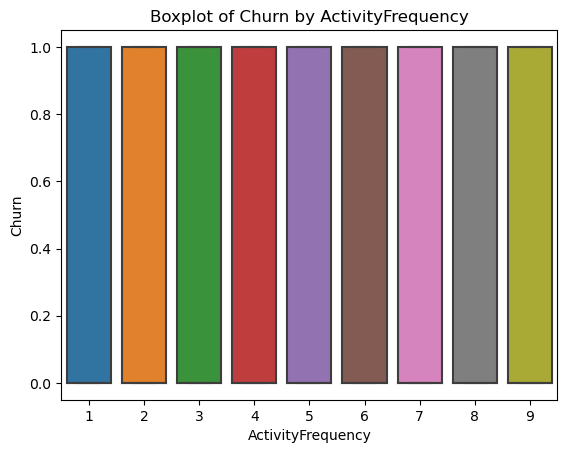

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

def bivariate_analysis(df, x, y):
    """
    Performs bivariate analysis between two columns using a boxplot.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        x (str): The name of the column for the x-axis.
        y (str): The name of the column for the y-axis.
    """
    sns.boxplot(x=x, y=y, data=df)
    plt.title(f"Boxplot of {y} by {x}")
    plt.show()

# Example usage
# Assuming df is your DataFrame and 'column1', 'column2' are valid column names
bivariate_analysis(df, list(X.columns)[-1], y.columns[0])



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def univariate_analysis(df, column):
    """
    Performs univariate analysis on a specified column.
    """
    sns.histplot(df[column])
    plt.show()
univariate_analysis(df,list(df.columns))

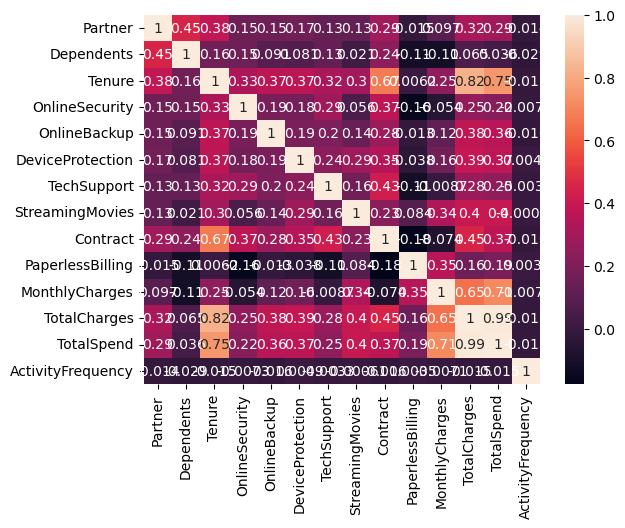

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_analysis(df):
    """
    Performs correlation analysis on the dataset.
    """
    sns.heatmap(df.corr(), annot=True)
    plt.show()
correlation_analysis(X)

8. Data Versioning
•	Use version control for raw and transformed datasets to ensure reproducibility:
o	Track changes in data using tools like DVC, Git LFS, or a custom tagging system
o	Store version metadata (e.g., source, timestamp, change log)
•	Deliverables:
o	DVC/Git repository showing dataset versions
o	Documentation of the versioning strategy and workflow


9. Model Building
•	Train a machine learning model to predict customer churn using the prepared features:
o	Use a framework like scikit-learn or TensorFlow
o	Experiment with multiple algorithms (e.g., logistic regression, random forest)
o	Evaluate model performance using metrics such as accuracy, precision, recall, and F1 score
•	Save the trained model using a versioning tool (e.g., MLflow)
•	Deliverables:
o	Python script for model training and evaluation
o	Model performance report
o	A versioned, saved model file (e.g., .pkl, .h5)


Random Forest Model

In [93]:

# Train Multi-output Random Forest Model
rcf_model = RandomForestClassifier( random_state=42)
rcf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [94]:
print(y_train.shape)

(5634, 1)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 1: Check class distribution
print("Class distribution in training data:", np.unique(y_train, return_counts=True))

# Step 2: Handle class imbalance (if necessary)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Check class distribution
print("Class distribution in training data:", np.unique(y_train, return_counts=True))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.unique(y_train_resampled, return_counts=True))

# Step 4: Evaluate on training data
train_predictions = rcf_model.predict(X_train)
print("Training predictions:", np.unique(train_predictions, return_counts=True))

# Step 5: Evaluate on test data
test_predictions = rcf_model.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)  # Adjust threshold if needed
print("Test predictions:", np.unique(test_predictions, return_counts=True))

# Step 6: Print classification report
print(classification_report(y_test, test_predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, test_predictions))

In [99]:
# Save model and scaler
with open('./models/random_forest_model.pkl', 'wb') as file:
    pickle.dump({'model': rcf_model, 'scaler': scaler, 'encoders': label_encoders}, file)


In [100]:
# Predictions
y_pred = rcf_model.predict(X_test)

In [101]:
y_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [102]:


# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}\n")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Model Accuracy: 0.7963

Confusion Matrix:
 [[937  99]
 [188 185]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1036
           1       0.65      0.50      0.56       373

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.80      0.79      1409



In [103]:
X.head(2)

,Partner,Dependents,Tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,TotalSpend,ActivityFrequency
0,1,0,0.013889,0,2,0,0,0,0,1,0.115423,0.001275,0.00,1
1,0,0,0.472222,2,0,2,0,0,1,0,0.385075,0.215867,0.18,1


In [104]:
X.columns

Index(['Partner', 'Dependents', 'Tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'TotalSpend',
       'ActivityFrequency'],
      dtype='object')

In [105]:
X['CustomerID'] = np.random.randint(10000, 99999, size=len(X))
X.head(2).to_csv('./test_data.csv',index=False)

In [106]:
# print("Training Features:", X.columns.tolist())

# Function to Predict from CSV
def predict_churn_from_csv(csv_file):
    input_df = pd.read_csv(csv_file)
    # print("testing features:",input_df.columns)
    print(categorical_features)
    print(label_encoders)
    # for col in categorical_features:
    #     if col in input_df.columns and col in label_encoders:
    #         input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
    for col in categorical_features:
        if col in input_df.columns and col in label_encoders:
            input_df[col] = input_df[col].astype(str).map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)

    input_df['TotalCharges'] = pd.to_numeric(input_df['TotalCharges'], errors='coerce')
    input_df.fillna(df.median(numeric_only=True), inplace=True)
    input_X = input_df.drop(columns=['CustomerID'], errors='ignore')
    input_X = scaler.transform(input_X)
    predictions = rcf_model.predict(input_X)
    result_df = input_df[['CustomerID']].copy()
    # result_df[['Churn_30', 'Churn_60', 'Churn_90']] = predictions
    result_df['Churn'] = predictions
    result_df.to_csv('./predicted_churn.csv', index=False)
    return result_df
result=predict_churn_from_csv('./test_data.csv')
result

['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
{'Gender': LabelEncoder(), 'Partner': LabelEncoder(), 'Dependents': LabelEncoder(), 'PhoneService': LabelEncoder(), 'MultipleLines': LabelEncoder(), 'InternetService': LabelEncoder(), 'OnlineSecurity': LabelEncoder(), 'OnlineBackup': LabelEncoder(), 'DeviceProtection': LabelEncoder(), 'TechSupport': LabelEncoder(), 'StreamingTV': LabelEncoder(), 'StreamingMovies': LabelEncoder(), 'Contract': LabelEncoder(), 'PaperlessBilling': LabelEncoder(), 'PaymentMethod': LabelEncoder(), 'Churn': LabelEncoder()}


,CustomerID,Churn
0,15300,0
1,93946,0


Logistic Regression Model

In [107]:
# Train Logistic Regression model
Lr_model = LogisticRegression()
Lr_model.fit(X_train, y_train)

LogisticRegression()

In [108]:
# Make predictions
y_pred = Lr_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}\n")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Model Accuracy: 0.8098

Confusion Matrix:
 [[932 104]
 [164 209]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.67      0.56      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [109]:
# print("Training Features:", X.columns.tolist())

# Function to Predict from CSV
def predict_churn_from_csv(csv_file):
    input_df = pd.read_csv(csv_file)
    # print("testing features:",input_df.columns)
    print(categorical_features)
    print(label_encoders)
    # for col in categorical_features:
    #     if col in input_df.columns and col in label_encoders:
    #         input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
    for col in categorical_features:
        if col in input_df.columns and col in label_encoders:
            input_df[col] = input_df[col].astype(str).map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)

    input_df['TotalCharges'] = pd.to_numeric(input_df['TotalCharges'], errors='coerce')
    input_df.fillna(df.median(numeric_only=True), inplace=True)
    input_X = input_df.drop(columns=['CustomerID'], errors='ignore')
    input_X = scaler.transform(input_X)
    predictions = rcf_model.predict(input_X)
    result_df = input_df[['CustomerID']].copy()
    # result_df[['Churn_30', 'Churn_60', 'Churn_90']] = predictions
    result_df['Churn'] = predictions
    result_df.to_csv('predicted_churn.csv', index=False)
    return result_df
result=predict_churn_from_csv('./test_data.csv')
result

['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
{'Gender': LabelEncoder(), 'Partner': LabelEncoder(), 'Dependents': LabelEncoder(), 'PhoneService': LabelEncoder(), 'MultipleLines': LabelEncoder(), 'InternetService': LabelEncoder(), 'OnlineSecurity': LabelEncoder(), 'OnlineBackup': LabelEncoder(), 'DeviceProtection': LabelEncoder(), 'TechSupport': LabelEncoder(), 'StreamingTV': LabelEncoder(), 'StreamingMovies': LabelEncoder(), 'Contract': LabelEncoder(), 'PaperlessBilling': LabelEncoder(), 'PaymentMethod': LabelEncoder(), 'Churn': LabelEncoder()}


,CustomerID,Churn
0,15300,0
1,93946,0


In [110]:
# Save model and scaler
with open('./models/LogisticRegression_model.pkl', 'wb') as file:
    pickle.dump({'model': rcf_model, 'scaler': scaler, 'encoders': label_encoders}, file)


10. Orchestrating the Data Pipeline
•	Automate the entire pipeline using an orchestration tool (e.g., Apache Airflow, Prefect, or Kubeflow):
o	Define a Directed Acyclic Graph (DAG) for pipeline tasks.
o	Ensure task dependencies are well-defined (e.g., ingestion → validation → preparation).
o	Monitor pipeline runs and handle failures gracefully.
•	Deliverables:
o	Pipeline DAG/script showcasing task automation
o	Screenshots of successful pipeline runs in the orchestration tool
o	Logs or monitoring dashboard screenshots


DAG CODE FOR AIRFLOW

from airflow import DAG
from airflow.operators.python import PythonOperator
import sys

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import json
import time
from datetime import datetime,timedelta
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2025, 3, 12),
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'churn_prediction_pipeline',
    default_args=default_args,
    description='Automated Churn Prediction Pipeline',
    schedule_interval='@daily',
    catchup=False
)

def fetch_data():
    df = pd.read_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/data/processed_customer_data_for_database.csv')
    df.to_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/data/data/staging_data.csv', index=False)

def process_data():
    df = pd.read_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/data/processed_customer_data_for_database.csv')
    df.to_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/data/processed_customer_data_for_database.csv', index=False)

def train_model():
    df = pd.read_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/data/processed_customer_data_for_database.csv')
    X = df.drop(columns=['Churn', 'CustomerID'])
    y = df['Churn']
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    model.fit(X, y)
    
    joblib.dump(model, '/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/models/random_forest_model.pkl')

def predict_churn():
    df = pd.read_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/test_data.csv')
    input_X = df.drop(columns=['CustomerID'])
    model = joblib.load('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/models/random_forest_model.pkl')
    predictions = model['model'].predict(input_X)
    df['PredictedChurn'] = predictions
    df.to_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/models/predicted_churn.csv', index=False)

def store_predictions():
    df = pd.read_csv('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/models/predicted_churn.csv')

    conn = sqlite3.connect('/home/checkout/Desktop/api_project/08_03_2025/customer_churn_prediction/db/database.db')
    df[['CustomerID', 'PredictedChurn']].to_sql('churn_predictions', conn, if_exists='replace', index=False)
    conn.close()

task_fetch_data = PythonOperator(
    task_id='fetch_data',
    python_callable=fetch_data,
    dag=dag
)

task_process_data = PythonOperator(
    task_id='process_data',
    python_callable=process_data,
    dag=dag
)

task_train_model = PythonOperator(
    task_id='train_model',
    python_callable=train_model,
    dag=dag
)

task_predict_churn = PythonOperator(
    task_id='predict_churn',
    python_callable=predict_churn,
    dag=dag
)

task_store_predictions = PythonOperator(
    task_id='store_predictions',
    python_callable=store_predictions,
    dag=dag
)

task_fetch_data >> task_process_data >> task_train_model >> task_predict_churn >> task_store_predictions


PIPELINE IMAGE

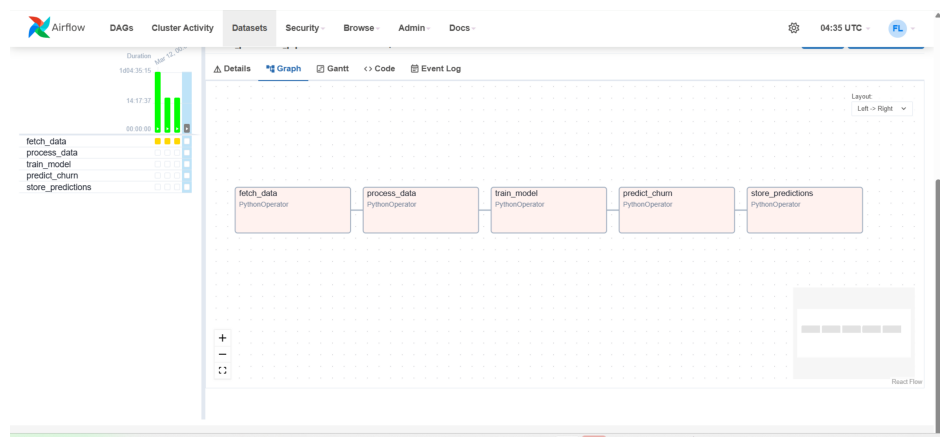

In [111]:
# Load image using PIL
img_path = "./airflow_pipeline/flow.png"
img = Image.open(img_path)

# Convert to NumPy array
img_array = np.array(img)

# Increase figure size
plt.figure(figsize=(12, 8))  # Adjust size (width, height)

# Display using matplotlib
plt.imshow(img_array, cmap="gray")  
plt.axis("off")  
plt.show()


DETAILS OF CHURN_PREDICTION_PIPELINE IMAGE

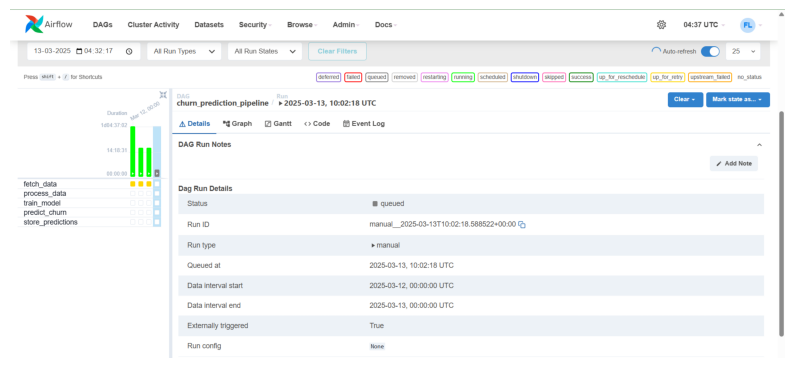

In [112]:

# Load image using PIL
img_path = "./airflow_pipeline/details.png"
img = Image.open(img_path)

# Convert to NumPy array
img_array = np.array(img)
# Increase figure size
plt.figure(figsize=(10, 8))  # Adjust size (width, height)
# Display using matplotlib
plt.imshow(img_array, cmap="gray")  # Use cmap="gray" for grayscale images
plt.axis("off")  # Hide axis labels
plt.show()
